In [1]:
from IPython.display import clear_output
!pip install -U seaborn; clear;
clear_output()

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='whitegrid', color_codes=True)

In [3]:
mpl.rcParams['figure.figsize'] = (10,6)

In [4]:
def import_sn_data(fpath='sn_data.txt'):
    df = pd.read_csv(fpath, sep='\s+', index_col=0, na_values=['...', 'NaN'])
    df = clean_sn_data(df)
    return df
    
    
def clean_sn_data(df):
    df = (df
          .iloc[:,[0,1,9,10,14]]
          .loc[~df['v_siII'].isnull(), :]
         )
    return df

sn_data = import_sn_data()
display(sn_data.head())
display(sn_data.info(verbose=True))
display(sn_data.describe())

,SN_Host,v,v_siII,v_siII_err,SN_type
SN,,,,,
1998de,NGC252,4619,1.13,2.0,Iabg
1998dk,UGC139,3609,1.27,3.0,IaH
1998ef,UGC646,5019,1.33,2.0,IaH
1998es,NGC632,2868,1.18,2.0,IaT
1999aa,NGC2595,4572,1.04,2.0,IaT


<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 1998de to 2008hv
Data columns (total 5 columns):
SN_Host       165 non-null object
v             165 non-null int64
v_siII        165 non-null float64
v_siII_err    162 non-null float64
SN_type       157 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 7.7+ KB


None

,v,v_siII,v_siII_err
count,165.000000,165.000000,162.000000
mean,6467.975758,1.222909,3.563951
std,2946.705128,0.530474,2.069367
min,841.000000,0.500000,0.000000
25%,4418.000000,1.030000,2.000000
50%,6255.000000,1.100000,3.000000
75%,8692.000000,1.230000,5.000000
max,14732.000000,5.000000,10.000000


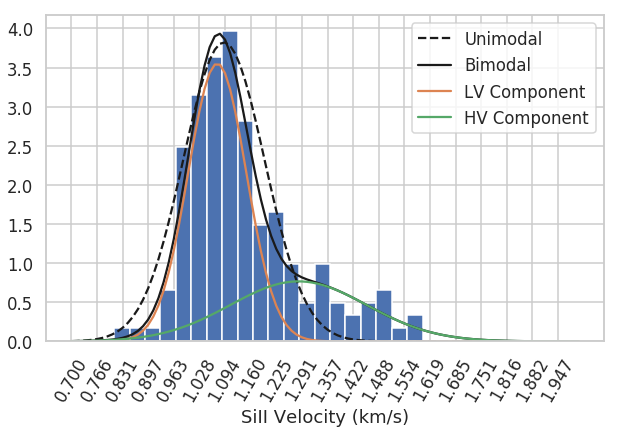

In [35]:
from scipy.optimize import curve_fit
from scipy.stats import norm

def gaussian(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

def bimodal_gaussian(x, mu1=0, sigma1=1, mu2=0, sigma2=1, g=0.5):
    """Bimodal independent gaussian"""
    return g*gaussian(x, mu1, sigma1) + (1-g)*gaussian(x, mu2, sigma2)

x = sn_data[(sn_data['v_siII'] < 2) & (sn_data['v_siII'] >0.7)]['v_siII']
xrange = np.linspace(0.7, 2, 100)
ydata, xdata = np.histogram(x, bins=20, density=True)
xdata = (xdata[:-1] + xdata[1:]) / 2
plt.hist(x, density=True, bins=20)

# Unimodal Gaussian
opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(x), np.std(x)])
plt.plot(xrange, gaussian(xrange, *opt), 'k--', label='Unimodal')

# Bimodal Gaussian
opt, cov = curve_fit(bimodal_gaussian, xdata, ydata, p0=[1.1, 1, 1.5, 1, 0.5])
plt.plot(xrange, bimodal_gaussian(xrange, *opt), 'k-', label='Bimodal')
plt.plot(xrange, opt[4]*gaussian(xrange, *opt[0:2]), label='LV Component')
plt.plot(xrange, (1-opt[4])*gaussian(xrange, *opt[2:4]), label='HV Component')

plt.xticks(xrange[::5], rotation=60)
plt.legend()
plt.xlabel('SiII Velocity ($10^4$ km/s)')

# Save results
np.savetxt('bimodal_params', opt)

http://mathworld.wolfram.com/SpherePointPicking.html

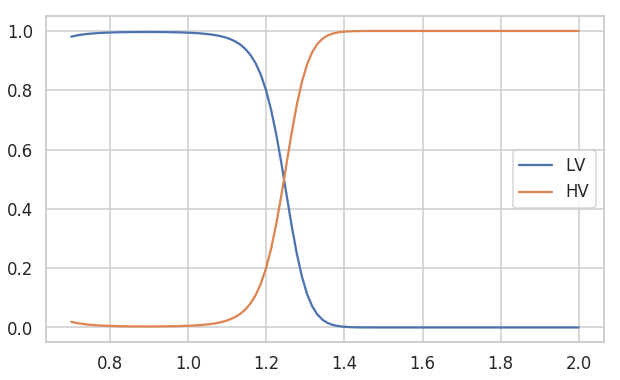

In [17]:
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

clf = GaussianMixture(n_components=2)
clf.fit(x[:,np.newaxis])

p = clf.predict_proba(xrange[:,np.newaxis])
plt.plot(xrange, p[:,0], label='LV')
plt.plot(xrange, p[:,1], label='HV')
plt.legend()

Text(0.5, 0, 'SiII Velocity (km/s)')

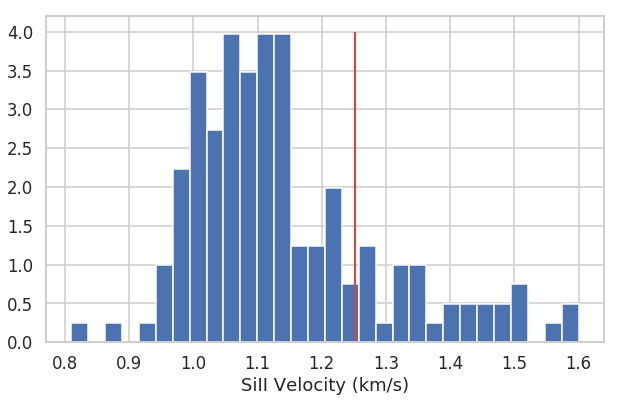

In [31]:
labels = clf.predict(x[:,np.newaxis])
hv = x[labels==1]
lv = x[labels==0]

plt.hist(x, label='SiII Velocity', density=True, bins=30)
boundary = xrange[np.argmin(np.abs(p[:,0] - p[:,1]))]
plt.vlines(boundary, 0, 4, 'r')
# plt.ylim(0,2e-4)

plt.xlabel('SiII Velocity ($10^4$ km/s)')

* MCMC
* KS Grid-search


* 2 or 3 parameters

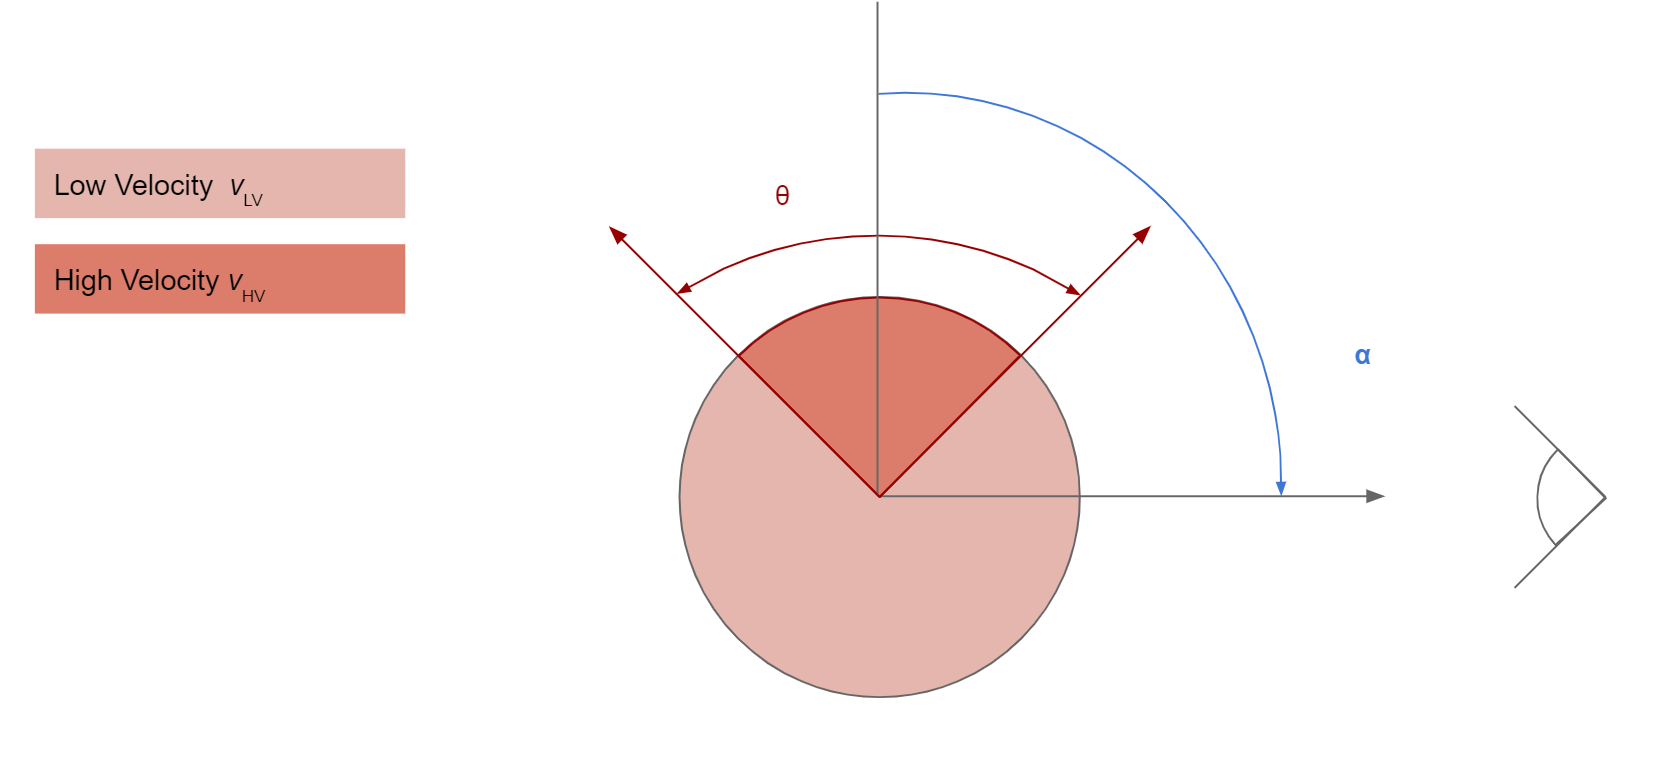

We can classify $D$ to high velocity SNe Ia (HV) and low velocity SNe Ia (LV) by some Bayes optimal rule.

$$
D = \begin{cases} \text{HV} & P(HV \mid D) > P(LV \mid D) \\ \text{LV} & \text{otherwise.} \end{cases}
$$

We wish to determine the posteriors of the parameters $w$ only using HV data,

$$
P(w \mid HV) \propto P(HV \mid w)P(w) 
$$

$$w = [\theta~,\quad \mu_\text{HV}~,\quad \mu_\text{LV}~,\quad \alpha]$$

Where

$$P(HV \mid w) = \prod P(HV \mid w_i)$$

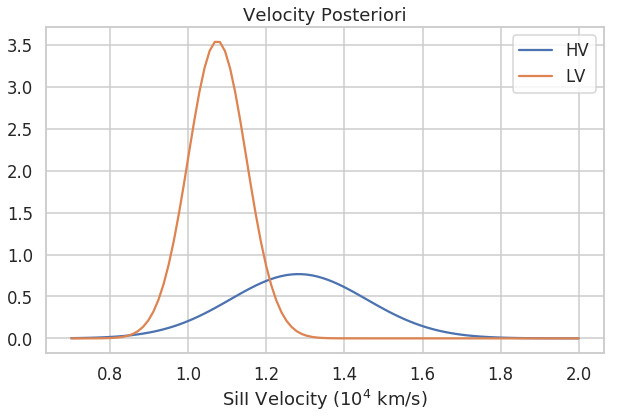

In [55]:
bimodal_params = np.loadtxt('bimodal_params')

def lv_prob(x):
    params = bimodal_params[0:2]
    return gaussian(x, *params)

def hv_prob(x):
    params = bimodal_params[2:4]
    return gaussian(x, *params)

def sample_lv(size=1):
    params = bimodal_params[0:2]
    return np.random.normal(*params, size=size)

def sample_hv(size=1):
    params = bimodal_params[2:4]
    return np.random.normal(*params, size=size)

plt.title('Velocity Posteriori')
plt.plot(xrange, (1-bimodal_params[-1])*hv_prob(xrange), label='HV')
plt.plot(xrange, bimodal_params[-1]*lv_prob(xrange), label='LV')
plt.xlabel('SiII Velocity ($10^4$ km/s)')
plt.legend();

## Semisphere Case

Assume $\theta = \pi$, then it must be that there's a 50% chance of observing the high velocity region as line of sight varies.

$$
P(HV \mid \theta=\pi) = 1/2
$$

The velocity observed is modeled by the sample.

$$
P(HV \mid \mu_\text{HV}) = \prod N(v,  )
$$

0.10552305636803527
157.8378378378378 deg


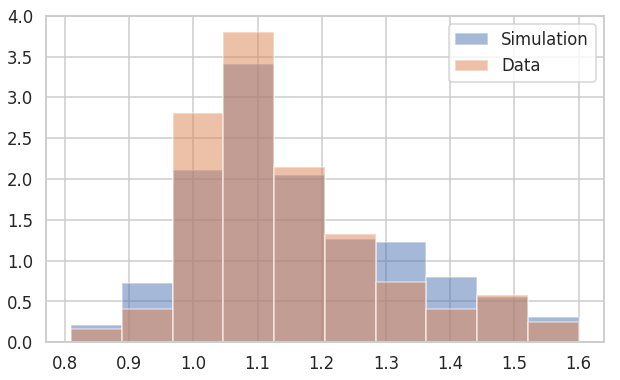

In [121]:
from scipy.stats import ks_2samp

param_grid = [
    np.linspace(0, 2*np.pi, 1000),
] 

# vs = []
# ks = []

# for theta in param_grid[0]:
#     v = []
#     for i in range(N):
#         los = np.random.uniform(-np.pi, np.pi)
#         if -theta/2 < los < theta/2:
#             v.append(sample_hv())
#         else:
#             v.append(sample_lv())

#     v = np.array(v).flatten()
#     vs.append(v)
#     ks.append(ks_2samp(x, v))
    
def simulate(param_grid, sample_size=1000):
    vs = []
    ks = []
    for theta in param_grid[0]:
        los = np.random.uniform(-np.pi, np.pi, sample_size)

        cond = (-theta/2 < los) & (-theta/2 < los)
        hv_size = np.sum(cond)
        lv_size = np.sum(~cond)

        v = np.append(
            sample_hv(hv_size),
            sample_lv(hv_size)
        )
        vs.append(v)
        ks.append(ks_2samp(x, v)[0])
    
    return vs, ks

vs, ks = simulate(param_grid, sample_size=1000)
best_id = np.argmin(ks)
best_ks = ks[best_id]
best_theta = param_grid[0][best_id]
v = vs[best_id]
bins = np.histogram(x)[1]
plt.hist(v, bins, density=True, alpha=0.5, label='Simulation')
plt.hist(x, bins, density=True, alpha=0.5, label='Data')
print(best_ks)
print(f"{best_theta * 180/np.pi} deg")
plt.legend();

In [192]:
from emcee import EnsembleSampler

def lnprob(params, x, v):
    """
    Arguments
    ---------
    params : array_like
         theta    - HV ejecta spread
         mu_HV    - HV mean
         sigma_HV - HV standard deviation
         mu_LV    - LV mean
         sigma_LV - LV standard deviation
    """
    lnp = lnprior(params)
    if not np.isfinite(lnp):
        return -np.inf
    
    lnl = lnlike(params, v)
    
    return lnl + lnp

    
def lnlike(params, v):
    scatter = params[-1]
    v_hat = model(*params[:-1])
    return -0.5*np.sum(((v-v_hat)/scatter)**2 + np.log(2*np.pi*scatter**2))
    

def lnprior(params):
    theta, mu_HV, sigma_HV, mu_LV, sigma_LV, scatter = params
    
    invalid = ~(
        (0 <= theta < 2*np.pi) and
        sigma_HV > 0 and
        sigma_LV > 0 and
        mu_HV > 0 and
        mu_LV > 0 and
        scatter > 0
    )
    if invalid:
        return -np.inf
    
    lnp = np.sum([
        norm.logpdf(mu_HV, bimodal_params[2], bimodal_params[3]*2),
        norm.logpdf(mu_LV, bimodal_params[0], bimodal_params[1]*2),
        norm.logpdf(theta, np.pi, 3.5)
    ])
    
    return lnp
    

def model(theta, mu_HV, sigma_HV, mu_LV, sigma_LV):
    los = np.random.uniform(-np.pi, np.pi)
    if -theta/2 < los < theta/2:
        return np.random.normal(mu_HV, sigma_HV)
    else:
        return np.random.normal(mu_HV, sigma_HV)

In [193]:
ndim, nwalkers = 6, 100
pos = [np.append(bimodal_params, 1) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=(x, x))
sampler.run_mcmc(pos, 5000);
np.save('chain', sampler.chain)

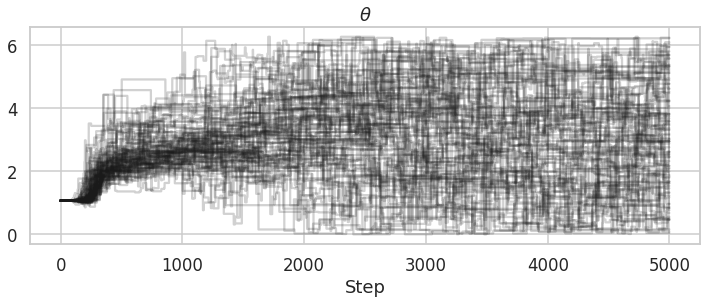

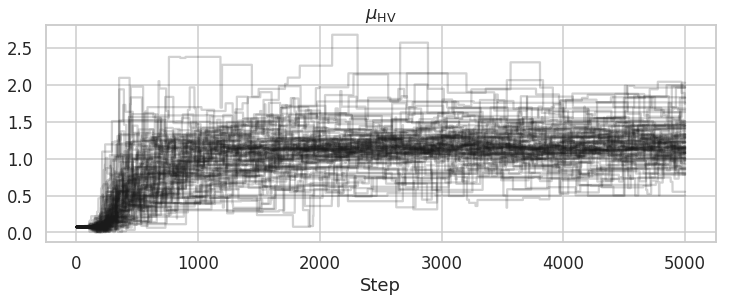

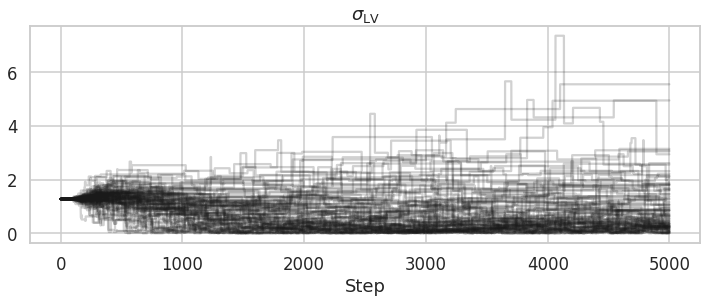

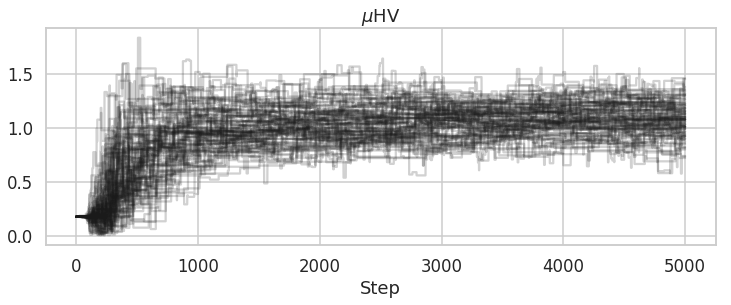

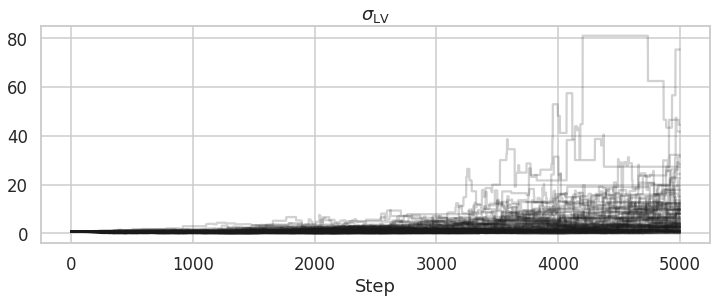

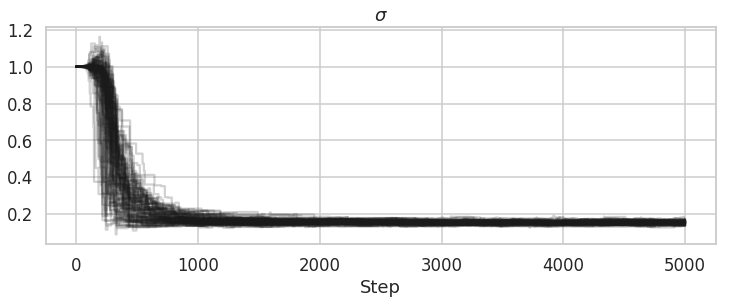

In [194]:
chain = np.load('chain.npy')

labels = [
    r'$\theta$',    
    r'$\mu_\mathrm{HV}$',    
    r'$\sigma_\mathrm{LV}$', 
    r'$\mu\mathrm{HV}$',    
    r'$\sigma_\mathrm{LV}$',
    r'$\sigma$'
] 

for dim_index in range(ndim):
    plt.figure(figsize=(12, 4))
    plt.title(labels[dim_index])
    plt.xlabel('Step')
    for walker_index in range(nwalkers):
        plt.plot(chain[walker_index, :, dim_index], 'k-', alpha=0.2)

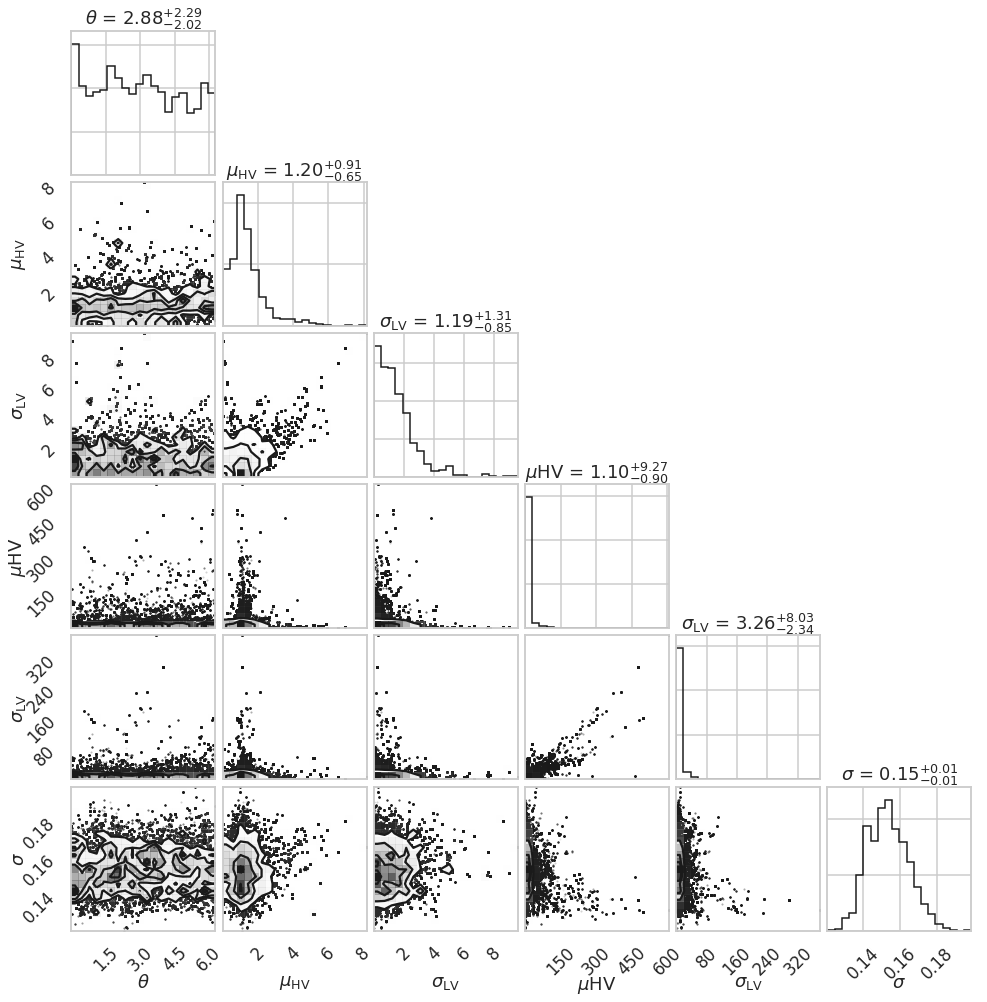

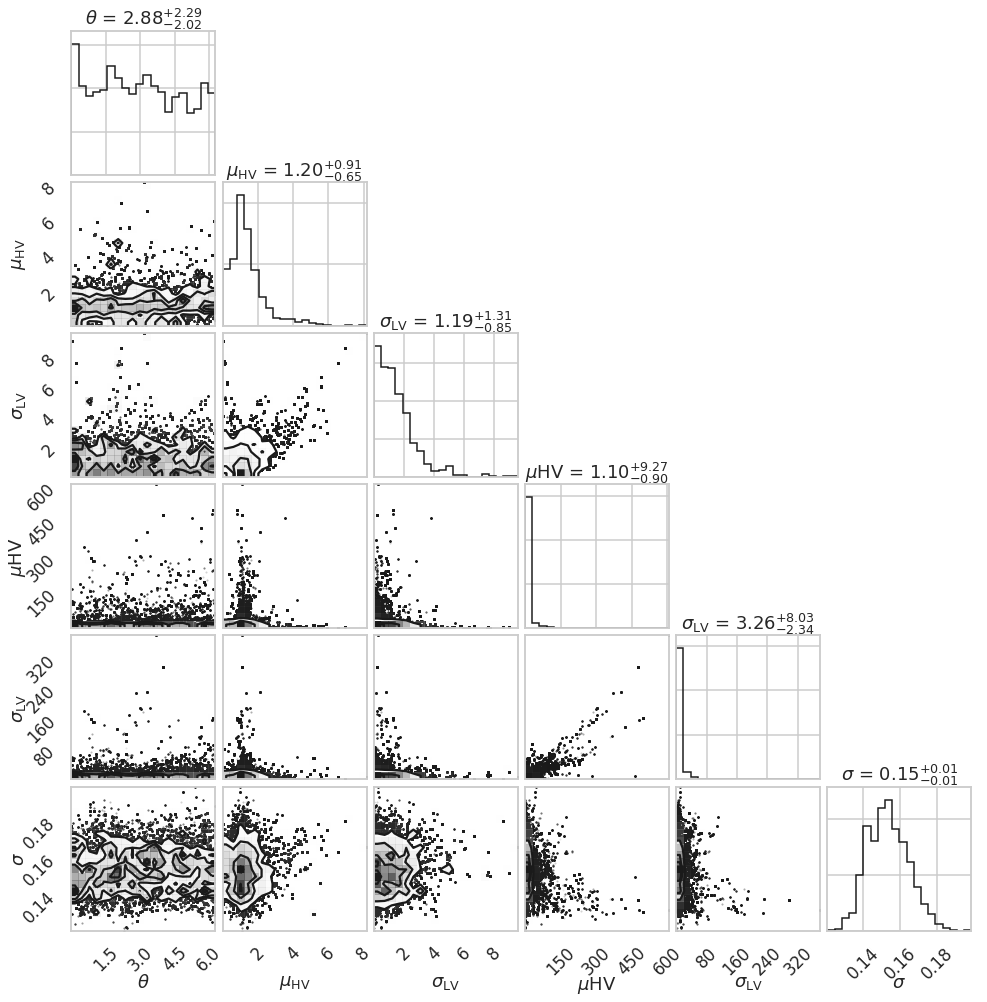

In [189]:
from corner import corner

burnin = 2000
samples = chain[:, burnin:, :].reshape((-1, ndim))
corner(samples, labels=labels, show_titles=True)